# Contrastive predictive coding - work in progress

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import torch.optim as optim
import h5py
import os
import random

## key idea

$X = [x_1, x_2, ..., x_n]$ is a vector of $N$ samples containing $1$ positive sample from $p(x_{t+k}|c_t)$ and $N-1$ negative samples drawn from the distribution $p(x_{t+k})$. These are the other samples in the batch at the same timestep $k$.

Each batch $X$ is of size $N * channel * seq$. We select one random time point between 0 and sequence len to be $t=0$. We use the same t for each sample $n$ in the batch.

Now, for each sample $n$ we need to compute:  
- the past context $c_t$
- the future encoded time steps $z_{t+1},z_{t+2},...,z_{t+k}$  

we will then teach the network to classify for each time step $k$, what is the correct $z_{t+k}$ among the $N$ samples within the batch, given the context $c_t$

$c_t$ for each $n$ is given by first encoding at once the whole batch $X$ until $t=0$, that is  $z_{t-k:t}=g_{enc}(X_{t-k:t})$. This returns a tensor of size $N * channel * seq$.  
Second we reshape $z_{t-k:t}$ to $N * seq * channel$ and pass it to $g_{ar}$, so that $c_t = g_{ar}(z_{t-k:t})$. This returns a tensor of shape $??$ (check what GRU returns)

$f_k(x_{t+k},c_t) = exp(z^T_{t+k} W_k c_t)$

For example, for a batch of N samples at time $t+k$ the correct output of $f_k(x_{t+k},c_t)$ is the identity matrix of size $NxN$.

\begin{bmatrix}
1,0,0,0 \\
0,1,0,0 \\
0,0,1,0 \\
0,0,0,1 
\end{bmatrix}



dataset: LibriSpeech - train-clean-100.tar.gz|

http://www.openslr.org/12/




## CPC architecture

In [12]:
class CPC(nn.Module):

    def __init__(self, n_timesteps, n_samples, seq_len):
        
        super(CPC, self).__init__()
        
        self.n_timesteps = n_timesteps
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.comp_rate = 160

        self.g_enc = nn.Sequential(
            
                        nn.Conv1d(1, 512, stride=5, kernel_size=10, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=4, kernel_size=8, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

        # autoregressive unit
        self.g_ar = nn.GRU(512, 256, batch_first=True)

        # list of W for each k timestep
        # note the input=256 from the GRU, output=512 to match the size of z
        self.W = nn.ModuleList([nn.Linear(256,512) for t in range(self.n_timesteps)])

        # softmax function to compute the prediction
        self.softmax = nn.Softmax(dim=0)

        # log softmax function to compute final loss
        self.log_softmax = nn.LogSoftmax(dim=0)


        def weights_initialization(module):

            if type(module) == nn.Conv1d:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.GRU:
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')


        self.apply(weights_initialization)



    # hidden state initialization with zeros for first gru loop
    def initialize_hidden(self, gpu=False): # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        if gpu:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size).cuda()
        else:
            hidden = torch.zeros(1, self.n_samples, self.g_ar.hidden_size)
            
        return hidden
    
    
    def forward(self, X, hidden):
        
        # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        z = self.g_enc(X)
        z = z.transpose(1,2)

        t = torch.randint(1, self.seq_len // self.comp_rate - self.n_timesteps, size=(1,))
#         print('random time sample: ',t)
        
        c_t = z[:,:t,:]
        c_t, hidden = self.g_ar(c_t)
        c_t = c_t[:,t-1,:].view(self.n_samples, 256)

        loss = 0
        acc = []

        for k in range(n_timesteps):

            w_k = self.W[k]
            y_k = w_k(c_t)

            z_k = z[:,t+k,:].view(self.n_samples,512)      

            f_k = torch.mm(z_k, y_k.transpose(0,1))
            
            # compute loss
            loss_k = self.log_softmax(f_k)
            loss_k = torch.diagonal(loss_k)
            loss_k = torch.sum(loss_k)

            loss += loss_k
            
            # compute correct output
            pred_k = self.softmax(f_k)
            pred_k = torch.argmax(pred_k, dim=0)
            
            gt_k = torch.arange(0, self.n_samples)
            
            corr_k = torch.eq(pred_k,gt_k)
            corr_k = torch.sum(corr_k)
            acc_k = corr_k.item()/self.n_samples
            
            acc.append(acc_k)
            

        loss *= -1
        loss /= self.n_samples*self.n_timesteps
        

        return loss, acc, hidden
    
    
    def predict(self, X, hidden):
        
        z = self.g_enc(X)
        z = z.transpose(1,2)
        c_t, hidden = self.g_ar(z)
        
        return c_t[:,-1,:], hidden

## Librispeech Dataset functions

In [3]:
class LibriSpeech100_dataset(Dataset):
    
    def __init__(self, data_path, seq_len, batch_size):
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.data = h5py.File(data_path, 'r')
        self.file_list = list(self.data.keys())
        self.file_list = self.file_list[:(len(self.file_list)//batch_size)*batch_size]
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        filename = self.file_list[idx]
        audio_file = self.data[filename][()]
        rnd_idx = np.random.randint(0, len(audio_file)-self.seq_len)
        audio_sample = audio_file[rnd_idx:rnd_idx+self.seq_len]
        audio_sample = audio_sample.reshape(1,-1)
        
        return audio_sample
    
    
def LibriSpeech100_preprocessing(file_list_path, data_path, output_path, seq_len):

    file_list = open(file_list_path).read().split('\n')[:100]
    dset_formatted = h5py.File(output_path, 'w')
    
    for filename in file_list:
#         print(filename)
        reader_id, chapter_id, _ = filename.split('-') 
        file_path = os.path.join(data_path,reader_id,chapter_id,filename)+'.flac'
#         print(file_path)
        audio_file, sr = sf.read(file_path)
        if audio_file.shape[0]>seq_len:
            dset_formatted.create_dataset(filename, data=audio_file)

    dset_formatted.close()

## train and validation functions

In [4]:
def train(model, optimizer, train_dataloader, device):

    model.train()
    total_train_loss = 0
    total_train_acc = []

    for idx_batch, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        hidden = model.initialize_hidden(gpu=gpu)
        loss, acc, hidden = model.forward(batch.float().to(device),hidden)

        loss.backward()
        optimizer.step()
        
        total_train_loss += len(batch) * loss
        total_train_acc.append(acc)

    total_train_loss /= len(train_dataloader.dataset)

    return total_train_loss, total_train_acc


def validation(model, valid_dataloader, device):

    model.eval()
    total_val_loss = 0
    total_val_acc = []


    with torch.no_grad():
        for idx_batch, batch in enumerate(valid_dataloader):
    #             print(batch.size())
            hidden = model.initialize_hidden(gpu=gpu)
            val_loss, val_acc, hidden = model.forward(batch.float().to(device), hidden)
            total_val_loss += len(batch) * val_loss
            total_val_acc.append(val_acc)


    total_val_loss /= len(valid_dataloader.dataset)
    
    return total_val_loss, total_val_acc

## data preprocessing

### custom train valid split

In [5]:
file_list_train_path = '/Users/yc00088/Documents/Affective_computing/projects/contrastive_predictive_coding/data/LibriSpeech100_labels_split/train_split.txt'

file_list = open(file_list_train_path).read().split('\n')
random.shuffle(file_list)

split_idx = int(len(file_list)*0.8)

train_set = file_list[:split_idx]
valid_set = file_list[split_idx:]

with open('data/labels_split/train_split.txt', 'w') as f:
    f.write('\n'.join(train_set))
f.close()

with open('data/labels_split/valid_split.txt', 'w') as f:
    f.write('\n'.join(valid_set))
f.close()

### preprocess and store dataset

In [19]:
data_path = '/Users/yc00088/Documents/Affective_computing/datasets/libri_speech/LibriSpeech/train-clean-100'
seq_len = 20480

train_file_list_path = 'data/labels_split/train_split.txt'
valid_file_list_path = 'data/labels_split/valid_split.txt'
test_file_list_path  = 'data/labels_split/test_split.txt'

train_output_path = 'data/processed_new/librispeech_train.hdf5'
valid_output_path = 'data/processed_new/librispeech_valid.hdf5'
test_output_path  = 'data/processed_new/librispeech_test.hdf5'

LibriSpeech100_preprocessing(train_file_list_path, data_path, train_output_path, seq_len)
LibriSpeech100_preprocessing(valid_file_list_path, data_path, valid_output_path, seq_len)
LibriSpeech100_preprocessing(test_file_list_path, data_path, test_output_path, seq_len)

## model and dataset initialization

In [5]:
gpu = False
seq_len = 20480
comp_rate = 160
n_timesteps = 12
n_samples = 8

In [6]:
train_data_path = 'data/processed_new/librispeech_train.hdf5'
valid_data_path = 'data/processed_new/librispeech_valid.hdf5'
test_data_path  = 'data/processed_new/librispeech_test.hdf5'

libri_train = LibriSpeech100_dataset(train_data_path,seq_len,n_samples)
libri_valid = LibriSpeech100_dataset(valid_data_path,seq_len,n_samples)
libri_test = LibriSpeech100_dataset(test_data_path,seq_len,n_samples)

In [7]:
train_dataloader = DataLoader(libri_train, batch_size=n_samples, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(libri_valid, batch_size=n_samples, shuffle=True, num_workers=0)
test_dataloader = DataLoader(libri_test, batch_size=n_samples, shuffle=True, num_workers=0)

In [13]:
device_type = 'cpu'

if gpu:
    device_type = 'cuda'

device = torch.device(device_type)

In [14]:
cpc_test = CPC(n_timesteps, n_samples, seq_len).to(device)

In [15]:
train_params = [p for p in cpc_test.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params)

## training

-- epoch 0 --
train loss: 0.929897129535675
valid loss: 1.0376471281051636


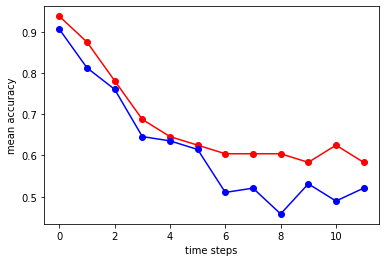

-- epoch 1 --
train loss: 0.9899246096611023
valid loss: 0.9456625580787659


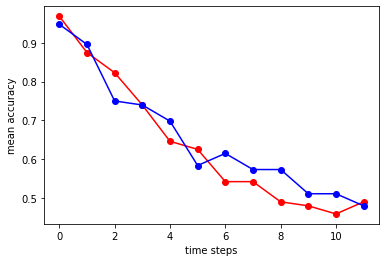

-- epoch 2 --
train loss: 1.040596842765808
valid loss: 1.0104881525039673


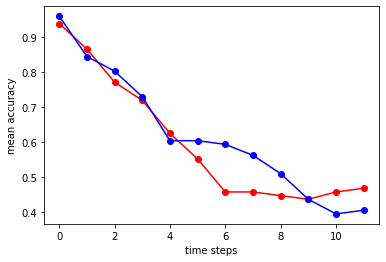

-- epoch 3 --
train loss: 0.9832184314727783
valid loss: 0.8697335124015808


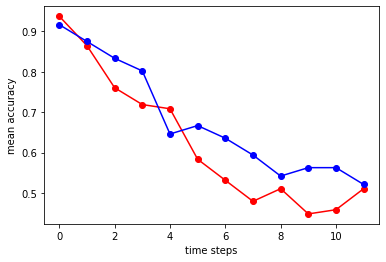

-- epoch 4 --
train loss: 0.978123664855957
valid loss: 0.9529127478599548


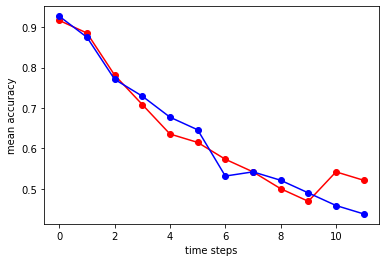

-- epoch 5 --
train loss: 0.9520633816719055
valid loss: 0.8485495448112488


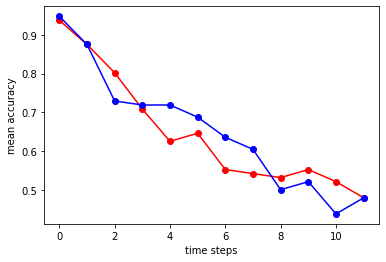

-- epoch 6 --
train loss: 0.870129406452179
valid loss: 0.9807226061820984


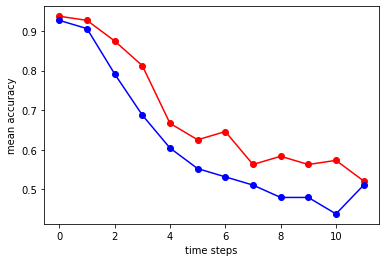

-- epoch 7 --
train loss: 1.0304855108261108
valid loss: 0.8776268362998962


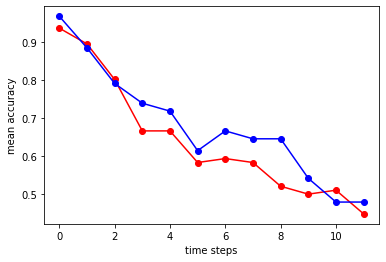

-- epoch 8 --
train loss: 0.784001886844635
valid loss: 0.938960611820221


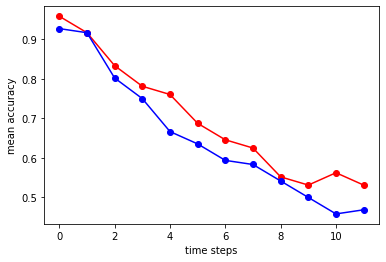

-- epoch 9 --
train loss: 1.0127226114273071
valid loss: 0.928270161151886


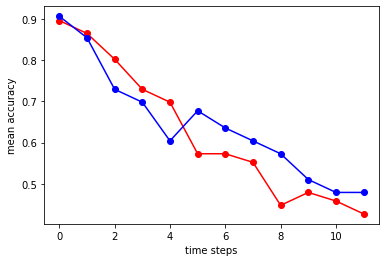

-- epoch 10 --
train loss: 0.8507420420646667
valid loss: 1.0096791982650757


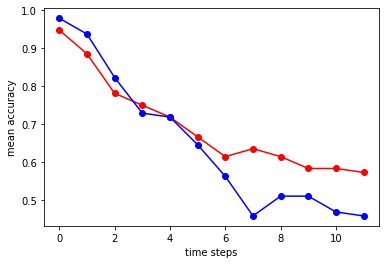

-- epoch 11 --
train loss: 1.002578854560852
valid loss: 1.0103586912155151


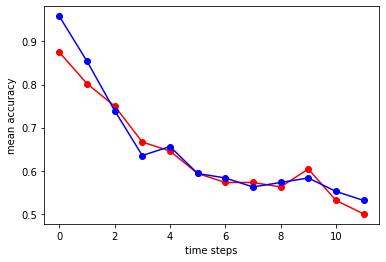

-- epoch 12 --
train loss: 0.9128004908561707
valid loss: 0.9285995364189148


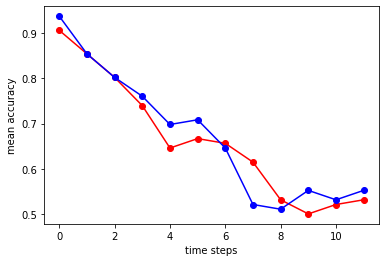

-- epoch 13 --
train loss: 0.9094791412353516
valid loss: 1.0060930252075195


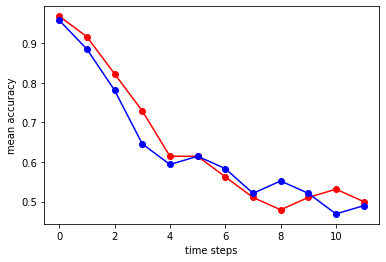

-- epoch 14 --
train loss: 1.01059889793396
valid loss: 1.0615037679672241


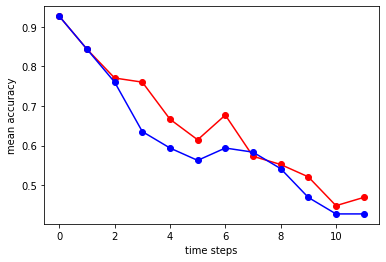

-- epoch 15 --
train loss: 0.8515448570251465
valid loss: 0.8605753779411316


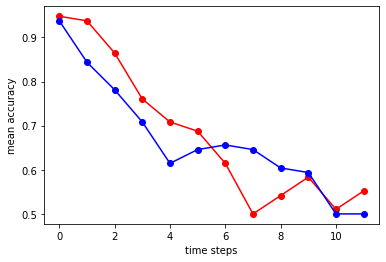

-- epoch 16 --
train loss: 1.0480329990386963
valid loss: 1.0112088918685913


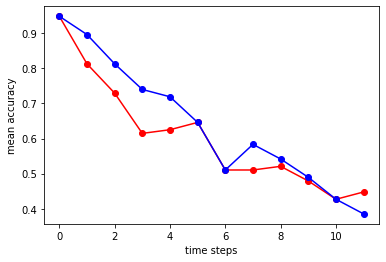

-- epoch 17 --
train loss: 0.99960857629776
valid loss: 0.9870598912239075


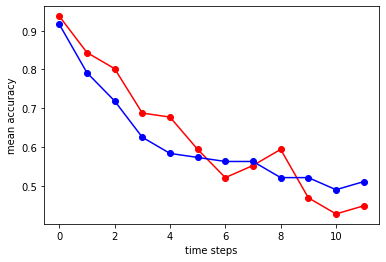

-- epoch 18 --
train loss: 0.9028229713439941
valid loss: 0.893632709980011


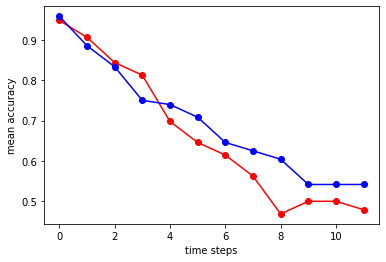

-- epoch 19 --
train loss: 1.0933656692504883
valid loss: 1.0757337808609009


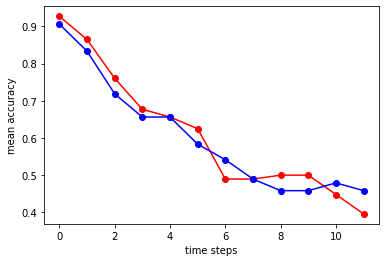

-- epoch 20 --
train loss: 0.8868337273597717
valid loss: 0.9462552666664124


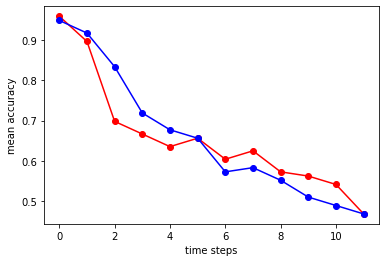

-- epoch 21 --
train loss: 0.8931911587715149
valid loss: 0.9543039202690125


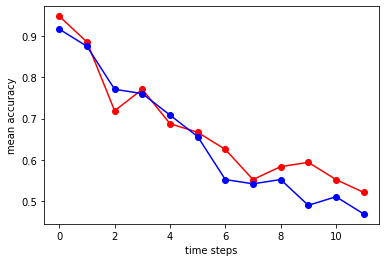

-- epoch 22 --
train loss: 0.9491300582885742
valid loss: 0.9062008857727051


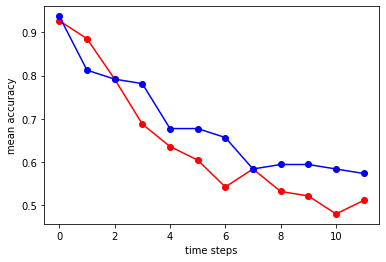

-- epoch 23 --
train loss: 1.0086214542388916
valid loss: 1.0976547002792358


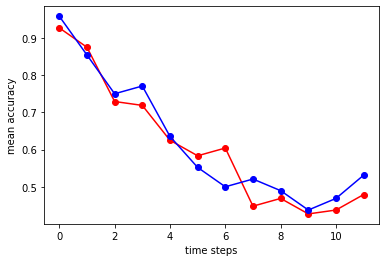

-- epoch 24 --
train loss: 0.8566833138465881
valid loss: 1.0287630558013916


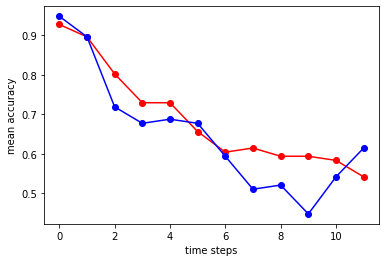

-- epoch 25 --
train loss: 0.9240953326225281
valid loss: 1.0474084615707397


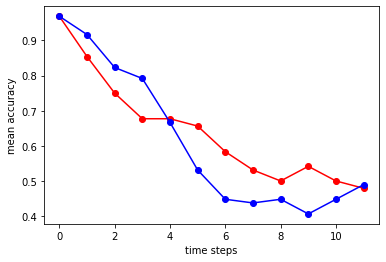

-- epoch 26 --
train loss: 1.0295459032058716
valid loss: 1.0643198490142822


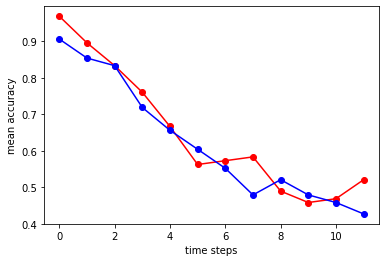

-- epoch 27 --
train loss: 0.8422855734825134
valid loss: 1.0049316883087158


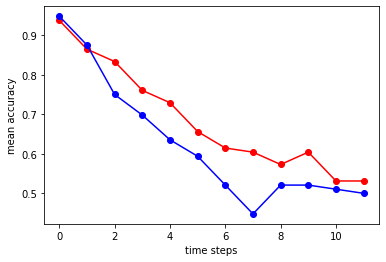

-- epoch 28 --
train loss: 0.8209394812583923
valid loss: 0.8683986663818359


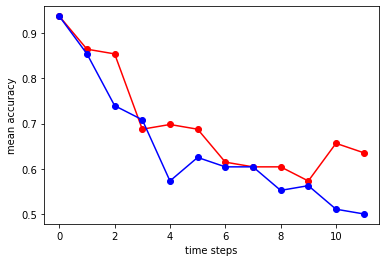

-- epoch 29 --
train loss: 0.9935670495033264
valid loss: 0.9376304745674133


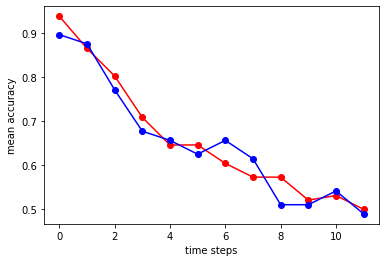

-- epoch 30 --
train loss: 1.1255284547805786
valid loss: 0.9972664713859558


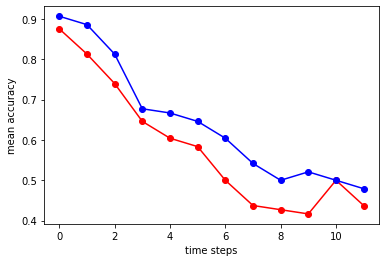

-- epoch 31 --
train loss: 0.9695101380348206
valid loss: 1.044393539428711


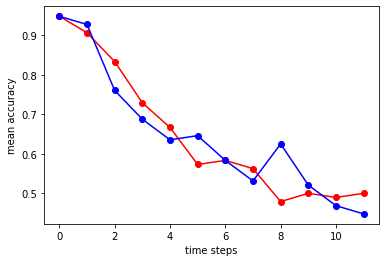

-- epoch 32 --
train loss: 0.853160560131073
valid loss: 1.180547833442688


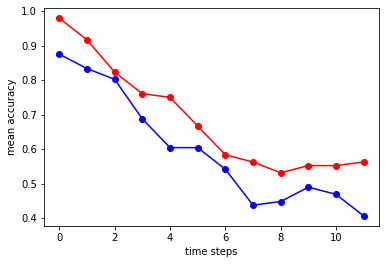

-- epoch 33 --
train loss: 0.8653313517570496
valid loss: 0.8952695727348328


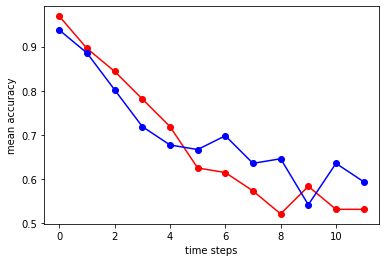

-- epoch 34 --
train loss: 0.8618133068084717
valid loss: 1.0059343576431274


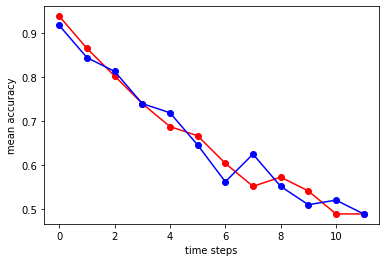

-- epoch 35 --
train loss: 0.9885407090187073
valid loss: 0.9615688323974609


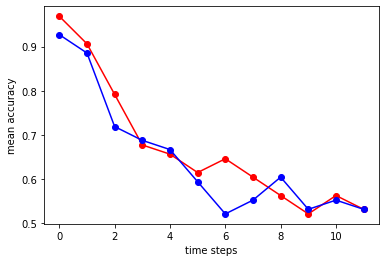

-- epoch 36 --
train loss: 0.8833324313163757
valid loss: 0.9473788738250732


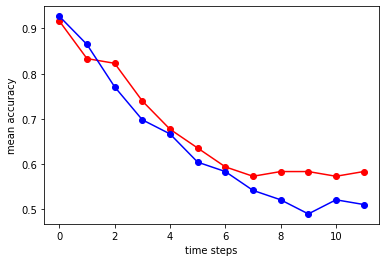

-- epoch 37 --
train loss: 0.7901125550270081
valid loss: 0.8101124167442322


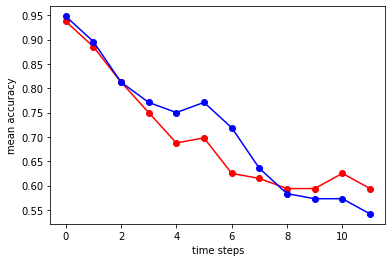

-- epoch 38 --
train loss: 0.957763671875
valid loss: 1.073277473449707


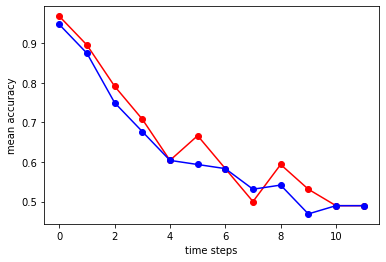

-- epoch 39 --
train loss: 0.930468738079071
valid loss: 0.952735185623169


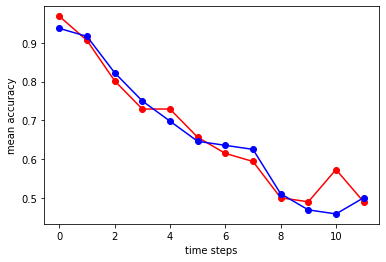

-- epoch 40 --
train loss: 0.8543849587440491
valid loss: 0.8427467346191406


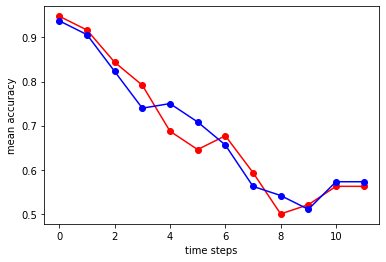

-- epoch 41 --
train loss: 0.972191572189331
valid loss: 0.9310259819030762


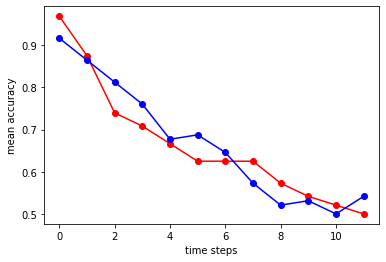

-- epoch 42 --
train loss: 0.9406856894493103
valid loss: 0.9057428240776062


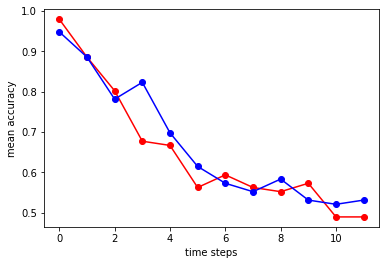

-- epoch 43 --
train loss: 0.8595950603485107
valid loss: 0.8908194899559021


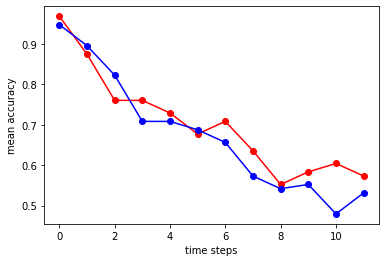

-- epoch 44 --
train loss: 0.8245790004730225
valid loss: 0.9261015057563782


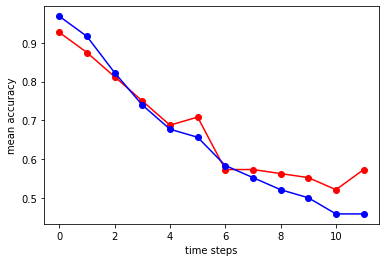

-- epoch 45 --
train loss: 1.0493202209472656
valid loss: 1.0360875129699707


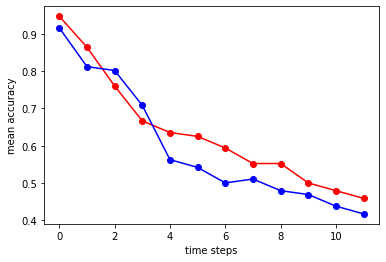

-- epoch 46 --
train loss: 0.8931567072868347
valid loss: 1.026635766029358


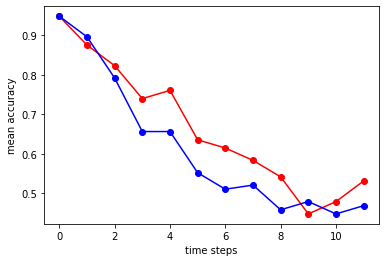

-- epoch 47 --
train loss: 0.9735400676727295
valid loss: 0.9538218975067139


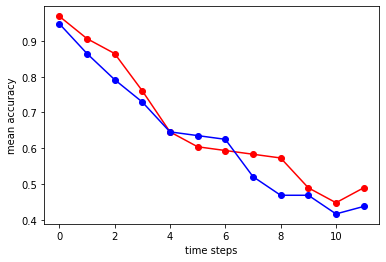

-- epoch 48 --
train loss: 0.8170241713523865
valid loss: 1.0333940982818604


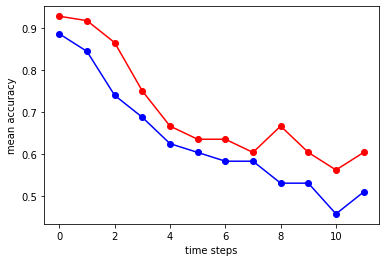

-- epoch 49 --
train loss: 0.8421462178230286
valid loss: 0.8821003437042236


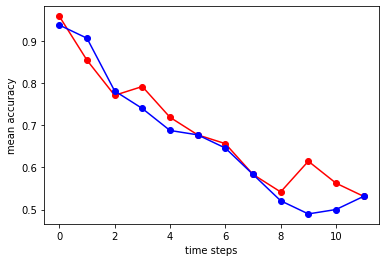

-- epoch 50 --
train loss: 0.9639979004859924
valid loss: 1.021335482597351


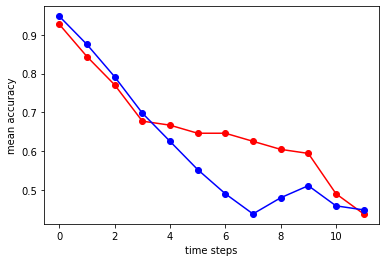

-- epoch 51 --
train loss: 0.9192888736724854
valid loss: 1.0491262674331665


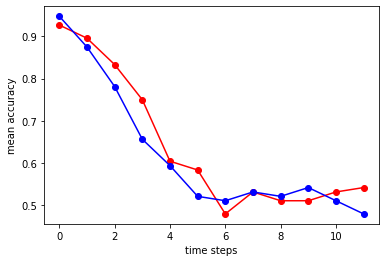

-- epoch 52 --
train loss: 1.0665595531463623
valid loss: 1.0074723958969116


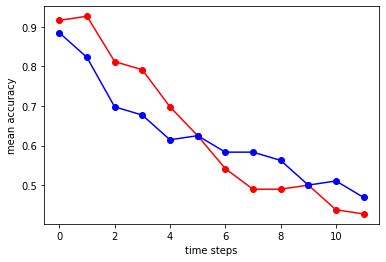

-- epoch 53 --
train loss: 1.0314432382583618
valid loss: 0.8845404982566833


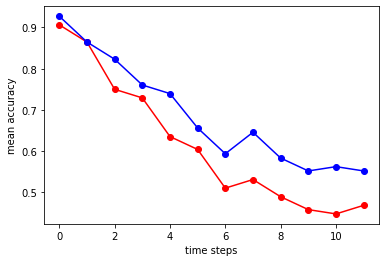

-- epoch 54 --
train loss: 0.9507609009742737
valid loss: 0.9411075711250305


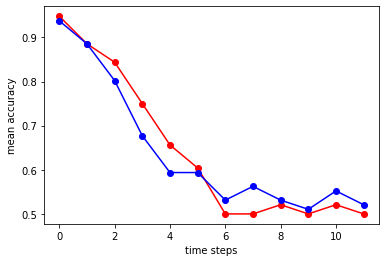

-- epoch 55 --
train loss: 0.7975918650627136
valid loss: 0.861996591091156


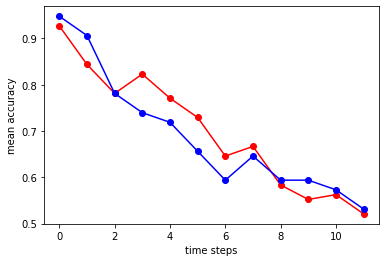

-- epoch 56 --
train loss: 0.8428637981414795
valid loss: 0.9914668202400208


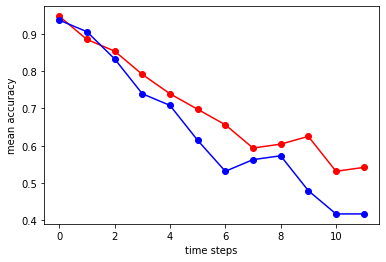

-- epoch 57 --
train loss: 0.7920380234718323
valid loss: 0.8841569423675537


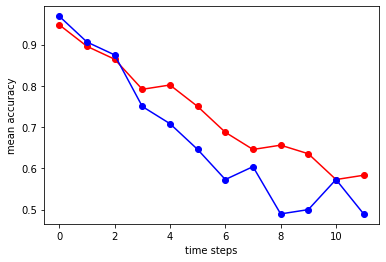

-- epoch 58 --
train loss: 0.7781855463981628
valid loss: 0.9939637184143066


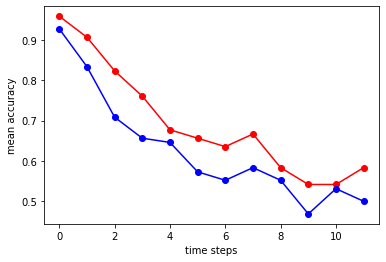

-- epoch 59 --
train loss: 1.123377799987793
valid loss: 0.9966921210289001


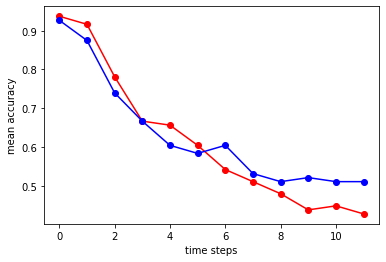

-- epoch 60 --
train loss: 0.9450905323028564
valid loss: 1.0794132947921753


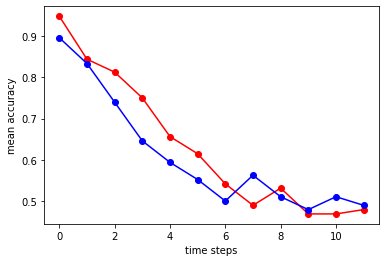

-- epoch 61 --
train loss: 0.9756643772125244
valid loss: 0.9761890769004822


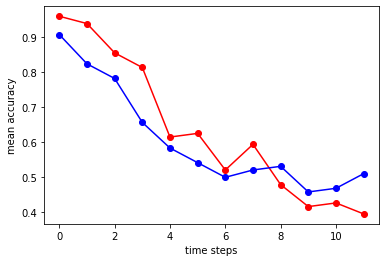

-- epoch 62 --
train loss: 0.7855357527732849
valid loss: 0.9686148762702942


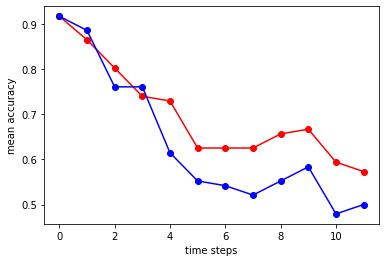

-- epoch 63 --
train loss: 0.9086295962333679
valid loss: 0.8449103236198425


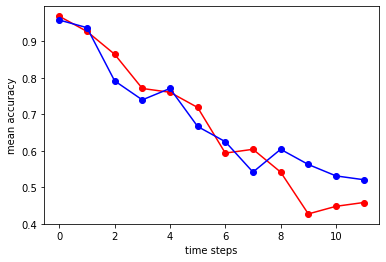

-- epoch 64 --
train loss: 0.8421717286109924
valid loss: 0.989857017993927


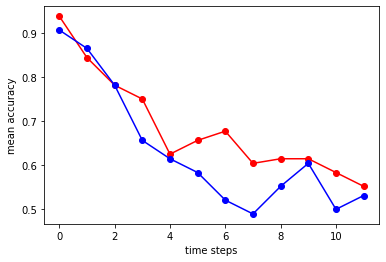

-- epoch 65 --
train loss: 0.9707362055778503
valid loss: 0.9121143221855164


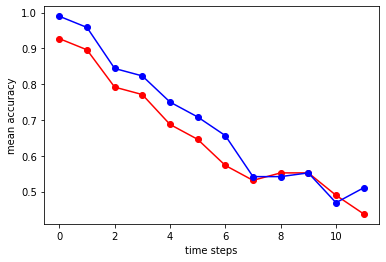

-- epoch 66 --
train loss: 0.8721129894256592
valid loss: 0.8479068279266357


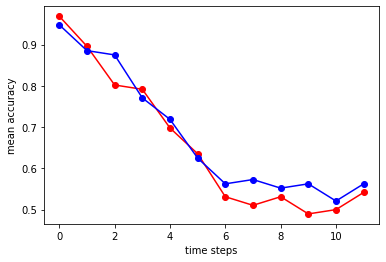

-- epoch 67 --
train loss: 0.8752878308296204
valid loss: 0.9859552979469299


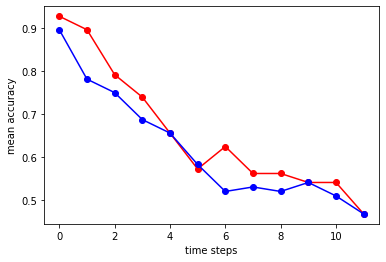

-- epoch 68 --
train loss: 0.8627415299415588
valid loss: 0.8045406937599182


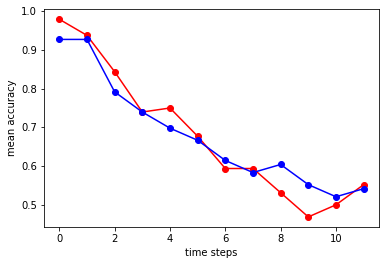

-- epoch 69 --
train loss: 0.8334197402000427
valid loss: 1.0649741888046265


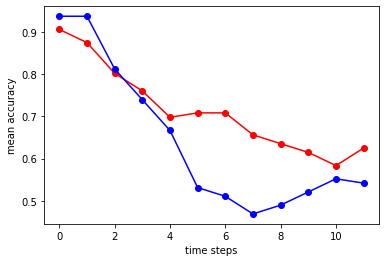

-- epoch 70 --
train loss: 0.9274021983146667
valid loss: 0.8963282704353333


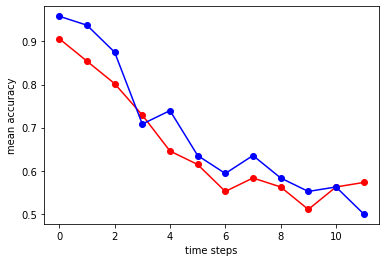

-- epoch 71 --
train loss: 0.9665247797966003
valid loss: 0.9023711085319519


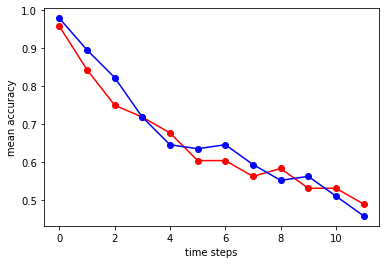

-- epoch 72 --
train loss: 0.9013833999633789
valid loss: 1.0826044082641602


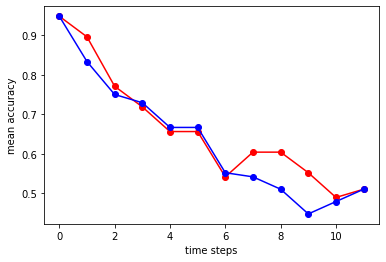

-- epoch 73 --
train loss: 0.9877384305000305
valid loss: 1.0079776048660278


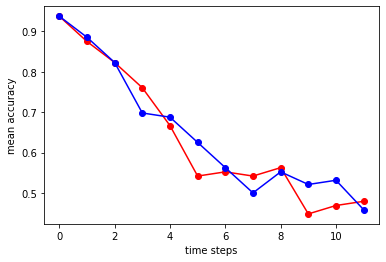

-- epoch 74 --
train loss: 0.8761842250823975
valid loss: 0.8813393115997314


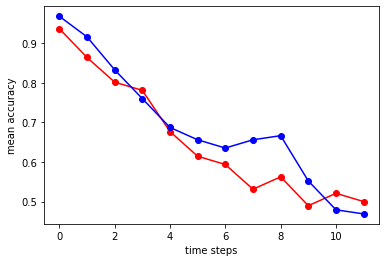

-- epoch 75 --
train loss: 0.8613281846046448
valid loss: 1.0526806116104126


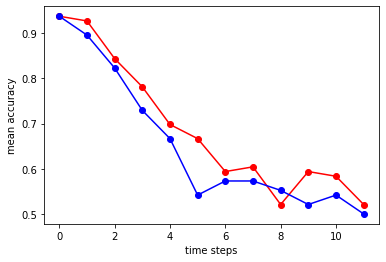

-- epoch 76 --
train loss: 0.8427795767784119
valid loss: 1.0374888181686401


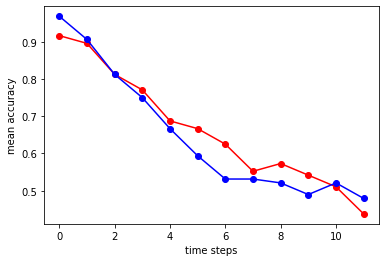

-- epoch 77 --
train loss: 0.9947444796562195
valid loss: 0.8448948264122009


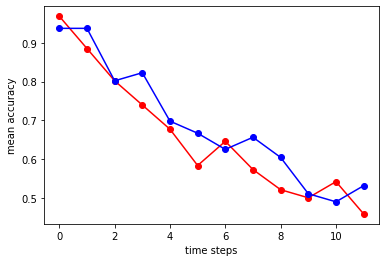

-- epoch 78 --
train loss: 0.9583352208137512
valid loss: 0.9464680552482605


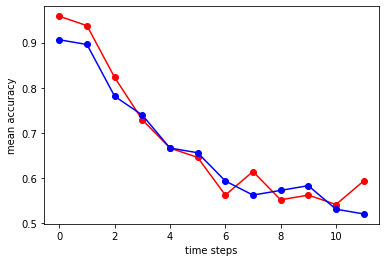

-- epoch 79 --
train loss: 0.9572885036468506
valid loss: 0.8093905448913574


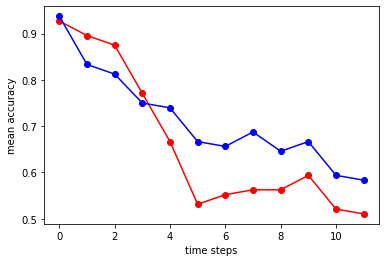

-- epoch 80 --
train loss: 0.7969603538513184
valid loss: 0.9451806545257568


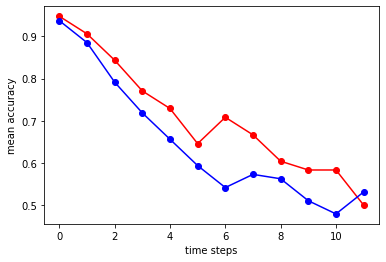

-- epoch 81 --
train loss: 0.9329707026481628
valid loss: 0.8682155609130859


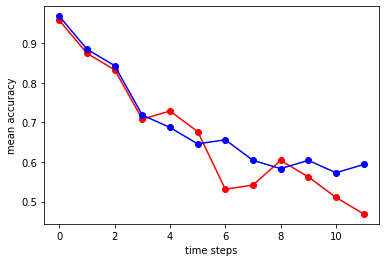

-- epoch 82 --
train loss: 0.7374100685119629
valid loss: 0.8840072751045227


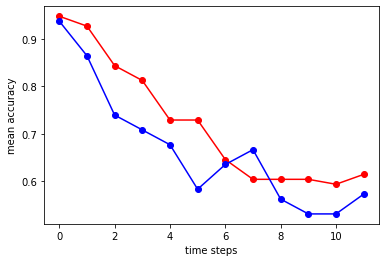

-- epoch 83 --
train loss: 0.9825141429901123
valid loss: 0.966793954372406


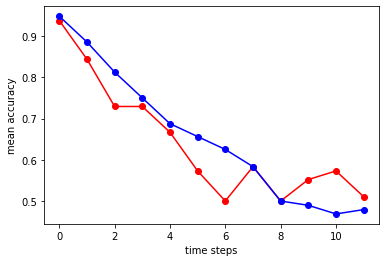

-- epoch 84 --
train loss: 0.800377607345581
valid loss: 0.9397087693214417


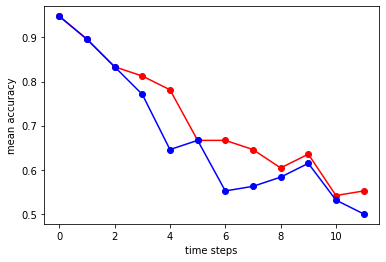

-- epoch 85 --
train loss: 0.8387736678123474
valid loss: 0.8508667349815369


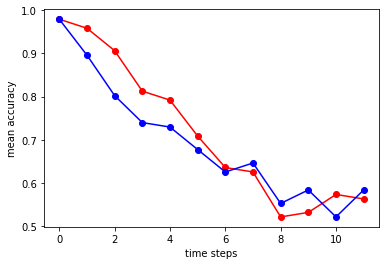

-- epoch 86 --
train loss: 0.8836045265197754
valid loss: 1.0060323476791382


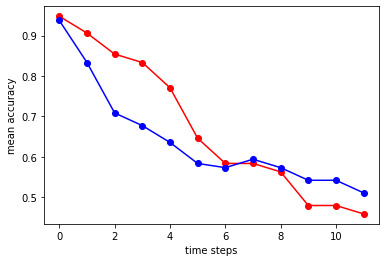

-- epoch 87 --
train loss: 0.8686234951019287
valid loss: 0.732279360294342


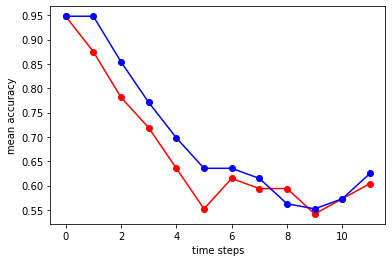

-- epoch 88 --
train loss: 0.8339855670928955
valid loss: 0.8892812132835388


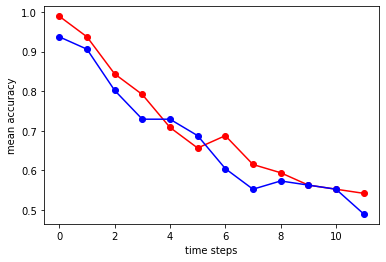

-- epoch 89 --
train loss: 0.9149494767189026
valid loss: 0.8439003825187683


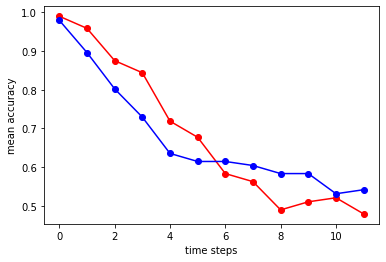

-- epoch 90 --
train loss: 0.882732093334198
valid loss: 0.8276810646057129


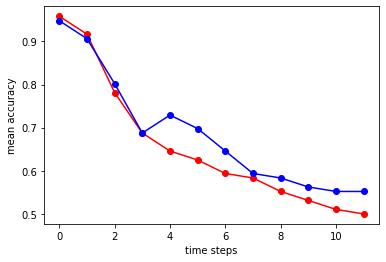

-- epoch 91 --
train loss: 0.8027510643005371
valid loss: 0.942817211151123


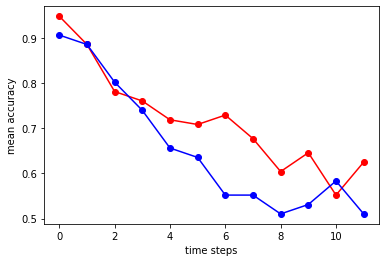

-- epoch 92 --
train loss: 0.8228535056114197
valid loss: 0.8470642566680908


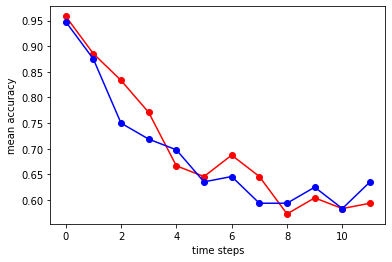

-- epoch 93 --
train loss: 0.8472191691398621
valid loss: 0.8988509178161621


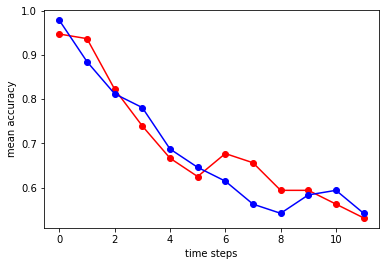

-- epoch 94 --
train loss: 1.0086255073547363
valid loss: 0.889174222946167


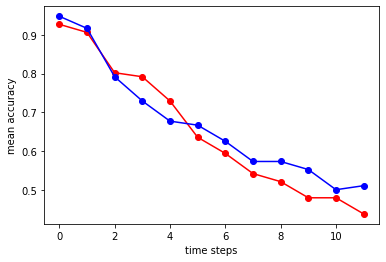

-- epoch 95 --
train loss: 0.759303092956543
valid loss: 0.863396406173706


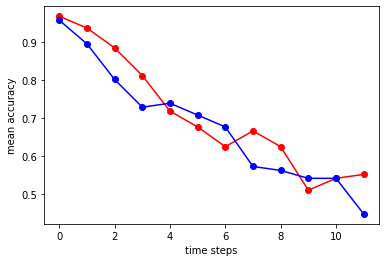

-- epoch 96 --
train loss: 0.7757155895233154
valid loss: 0.7791231274604797


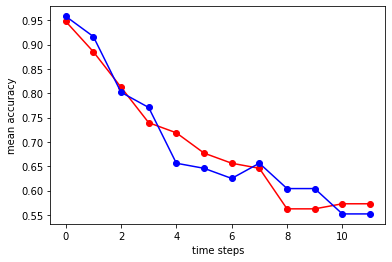

-- epoch 97 --
train loss: 0.765699565410614
valid loss: 0.8948349356651306


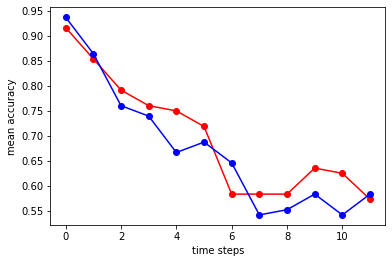

-- epoch 98 --
train loss: 0.7907671332359314
valid loss: 0.8360154628753662


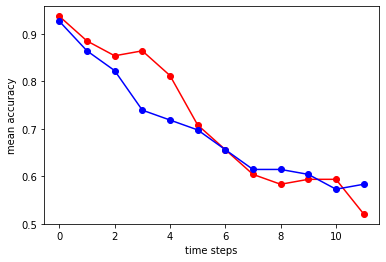

-- epoch 99 --
train loss: 0.8321053385734558
valid loss: 0.8531046509742737


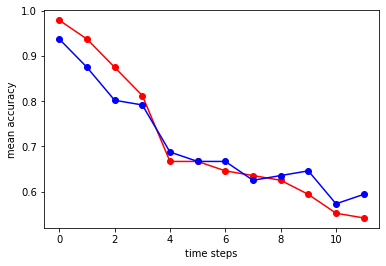

In [25]:
for epoch in range(100):

    total_train_loss, total_train_acc = train(cpc_test, optimizer, train_dataloader, device)
    total_valid_loss, total_valid_acc = validation(cpc_test, valid_dataloader, device)
    
    print('-- epoch {0} --'.format(epoch))
    print('train loss: {0}'.format(total_train_loss))
    print('valid loss: {0}'.format(total_valid_loss))
    
    
    plt.plot(np.mean(total_train_acc,0),'r-o')
    plt.ylabel('mean accuracy')
    plt.xlabel('time steps')

    plt.plot(np.mean(total_valid_acc,0),'b-o')
    plt.ylabel('mean accuracy')
    plt.xlabel('time steps')
    
    plt.show()

In [27]:
# ! ls trained_models/

cpc_speech_model_2020-10-15-16:24:33 cpc_speech_model_2021-11-04-12:26:37
cpc_speech_model_2021-11-04-10:12:36 cpc_speech_opti_2020-10-15-16:24:33
cpc_speech_model_2021-11-04-11:05:00


In [28]:
# import datetime
# save_model_folder = 'trained_models/'
# time_now = datetime.datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
# torch.save(cpc_test.state_dict(), save_model_folder+'cpc_speech_model_{0}'.format(time_now))

In [ ]:
class LibriSpeech100_dataset_spk_class(Dataset):
    
    def __init__(self, data_path, seq_len, batch_size):
        
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.data = h5py.File(data_path, 'r')
        self.file_list = list(self.data.keys())
        self.file_list = self.file_list[:(len(self.file_list)//batch_size)*batch_size]
        
        unique_spk_ids = np.unique([f.split('-')[0] for f in list(data.keys())])
        
        self.spk_labels = {}
        for i,s_id in enumerate(unique_spk_ids):
            self.spk_labels[s_id] = i
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        filename = self.file_list[idx]
        audio_file = self.data[filename][()]
        rnd_idx = np.random.randint(0, len(audio_file)-self.seq_len)
        audio_sample = audio_file[rnd_idx:rnd_idx+self.seq_len]
        audio_sample = audio_sample.reshape(1,-1)
        
        spk_id = filename.split('-')[0]
        speaker_label = self.spk_labels[spk_id]
        
        return audio_sample, speaker_label

In [ ]:
libri_train_spk = LibriSpeech100_dataset_spk_class(train_data_path,seq_len,n_samples)

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_dim, hidden_dim, n_labels):
        
        super(MLP, self).__init__()
        
        self.mlp = nn.Sequential(
            
            nn.Linear(input_dim,hidden_dim,bias=False),
#             nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,n_labels,bias=False)
        )
        
        def weights_initialization(module):

            if type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, 
                                        mode='fan_out', 
                                        nonlinearity='relu')
        
        self.log_softmax =nn.LogSoftmax(dim=-1)
        
        self.apply(weights_initialization)
        
        
        
    def forward(self,X):
        
        y = self.mlp(X)
#         y = self.log_softmax(y)
        
        return y

In [ ]:
mlp = MLP(256,512,10)

In [18]:
 2e-4

0.0002

In [32]:
data = h5py.File(train_output_path, 'r')
data_keys = list(data.keys())

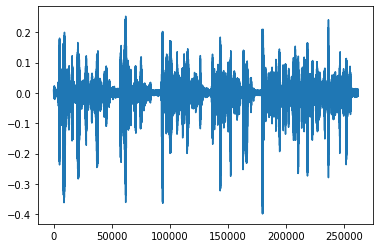

In [39]:
plt.plot(data[data_keys[0]][()])

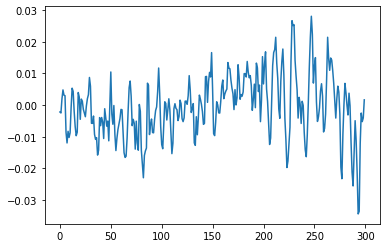

In [50]:
plt.plot(libri_train.__getitem__(0).squeeze()[:300])

In [51]:
for idx_batch, batch in enumerate(train_dataloader):
    
    print(batch.shape)
    
    break

torch.Size([8, 1, 20480])


In [103]:
cpc_test = CPC(n_timesteps, n_samples, seq_len).to(device)

In [104]:
hidden = cpc_test.initialize_hidden(gpu=gpu)
loss, acc, hidden, f_k = cpc_test.forward(batch.float().to(device),hidden)

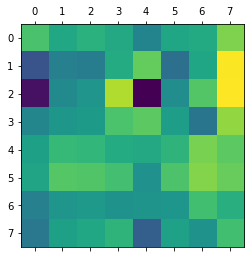

In [105]:
plt.matshow(f_k.detach().numpy())

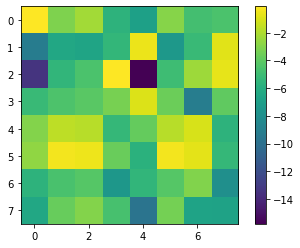

In [106]:
plt.imshow(cpc_test.log_softmax(f_k).detach().numpy())
plt.colorbar()